In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os 
pd.options.mode.chained_assignment = None

In [41]:
dir_name = './blocks/'
file_list = [dir_name + str(csv) for csv in os.listdir("./blocks") if csv.endswith(".csv")]
file_list

['./blocks/Blocks-202111_Saturday_202111G_10.csv',
 './blocks/Blocks-202111_Saturday_202111S_10.csv',
 './blocks/Blocks-202111_Sunday_202111G_5.csv',
 './blocks/Blocks-202111_Sunday_202111S_5.csv',
 './blocks/Blocks-202111_Weekday_202111G_0.csv',
 './blocks/Blocks-202111_Weekday_202111S_0.csv']

In [42]:
# file ="C:/Users/TylerDickens/Documents/Python Scripts/block_files/Blocks-202111_Saturday_202111G_10.csv"
# block = pd.read_csv(file)
frame_list = []
for csv in file_list:
    frame = pd.read_csv(csv)
    frame['filename'] = os.path.basename(csv)
    frame_list.append(frame)

block = frame_list[0]
for index, frame in enumerate(frame_list):
    if index == 0:
        next
    else:
        block = pd.concat([block, frame])

block = block.reset_index(drop=index)
block = block.drop(block[block['Veh'] == 'CAR'].index)
block = block.drop(columns='Veh')

In [43]:
block['TimeIn'] = np.where(block['TimeIn'].str.len() > 5, block['TimeIn'].str.slice(0,5), block['TimeIn'])
block['TimeOut'] = np.where(block['TimeOut'].str.len() > 5, block['TimeOut'].str.slice(0,5), block['TimeOut'])
block['Duration'] = np.where(block['Duration'].str.len() > 5, block['Duration'].str.slice(0,5), block['Duration'])
block['TimeOut_td'] = block['TimeOut'] + ':00'
block['TimeIn_td'] = block['TimeIn'] + ':00'
block['Duration_td'] = block['Duration'] + ':00'

In [44]:
block['TimeOut_td'] = pd.to_timedelta( block['TimeOut_td'] )
block['TimeIn_td'] = pd.to_timedelta( block['TimeIn_td'] )
block['Duration_td'] = pd.to_timedelta( block['Duration_td'] )
block['Ave Speed (mi/hr)'] = round(block['Distance'] /( block['Duration_td']/ np.timedelta64(1, 'h')),1)

In [45]:
FCEB_MIN = 317 #miles
FCEB_MAX = 645 #miles
BEB_675_MIN = 179 #miles
BEB_675_MAX = 310 #miles
BEB_450_MIN = 119 #miles
BEB_450_MAX = 207 #miles

### conditions
# =IF(Distance<=BEB_450_MIN,1,0)
zeb_c1 = block['Distance'] <= BEB_450_MIN
# =IF(AND(Distance<=BEB_675_MIN,Distance>BEB_450_MIN),1,0)
zeb_c2 = (block['Distance'] <= BEB_675_MIN) & (block['Distance'] > BEB_450_MIN)
# =IF(AND(BEB_675=0,BEB_450=0,Distance<=FCEB_MAX),1,0)
zeb_c3 = block['Distance'] <= FCEB_MAX

zeb_conditions = [zeb_c1, zeb_c2, zeb_c3]

### values
zeb_v1 = 'BEB 450 kWh'
zeb_v2 = 'BEB 675 kWh'
zeb_v3 = 'FCEB'

zeb_values = [zeb_v1, zeb_v2, zeb_v3]

block['Bus Type'] = np.select(zeb_conditions, zeb_values, default='No ZEV')
### drop routes that don't have values
block = block.drop(block[block['Duration_td'] <=  np.timedelta64(1, 'h')].index)
block.groupby('Bus Type')['Block'].agg('count')

Bus Type
BEB 450 kWh    143
BEB 675 kWh    213
FCEB           128
Name: Block, dtype: int64

<AxesSubplot:xlabel='Bus Type', ylabel='count'>

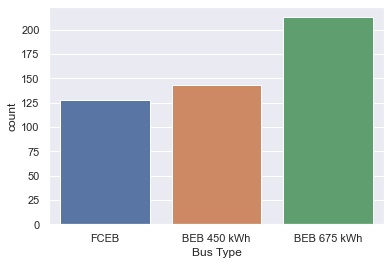

In [46]:
sns.set_theme()
sns.countplot(data=block, x='Bus Type', order=['FCEB', 'BEB 450 kWh', 'BEB 675 kWh'])

In [47]:
### if route is longer than 24 hr, assign to FCEB
block['Bus Type'] = np.where(block['Duration_td'] > np.timedelta64(1, 'D'), 'FCEB', block['Bus Type'])
block.groupby('Bus Type')['Block'].agg('count')


Bus Type
BEB 450 kWh    143
BEB 675 kWh    213
FCEB           128
Name: Block, dtype: int64

In [48]:
block['Charging Time'] = np.where(block['Bus Type'] == 'FCEB', None, (block['TimeOut_td'] - block['TimeIn_td'] )/np.timedelta64(1, 'h') +24)
hours = block['Charging Time'] - np.mod( block['Charging Time'], 1)
hours = [None if math.isnan(x) else int(x) for x in hours]
minutes = np.mod( block['Charging Time'], 1) * 60
minutes = [None if math.isnan(x) else int(x) for x in minutes]
charging_time = []
for hour, minute in zip(hours, minutes):
    if minute == None:
        charging_time.append('00:15:00')
    else:
        charging_time.append(str(hour) + ':' + str(minute)+ ':00')

block['Charging Time_td'] = pd.to_timedelta(charging_time)



<AxesSubplot:xlabel='Distance', ylabel='Count'>

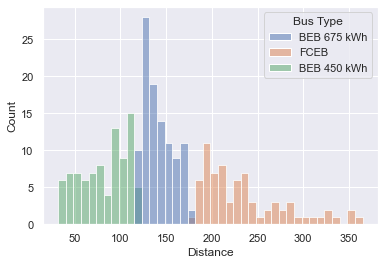

In [49]:
blocks = block.drop_duplicates(subset=['Block'])
sns.histplot(data=blocks, x='Distance', hue='Bus Type',  bins=40)

Bus Type
BEB 450 kWh     87
BEB 675 kWh    104
FCEB            73
Name: Block, dtype: int64


<AxesSubplot:xlabel='Bus Type', ylabel='count'>

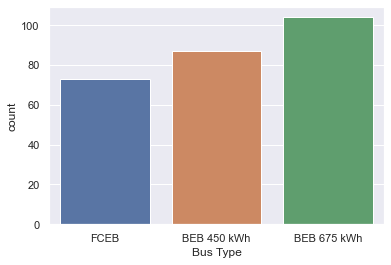

In [50]:
print(blocks.groupby('Bus Type')['Block'].agg('count'))
sns.countplot(data=blocks, x='Bus Type', order=['FCEB', 'BEB 450 kWh', 'BEB 675 kWh'])

C:\Users\TylerDickens\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


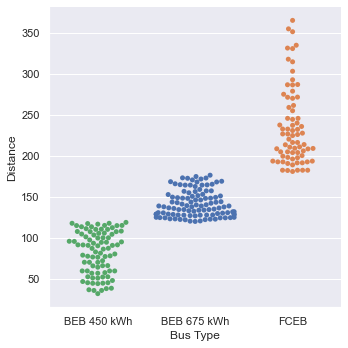

In [59]:
sns.catplot(data=blocks, x='Bus Type', y='Distance', hue='Bus Type', kind='swarm', order=[ 'BEB 450 kWh', 'BEB 675 kWh', 'FCEB'])

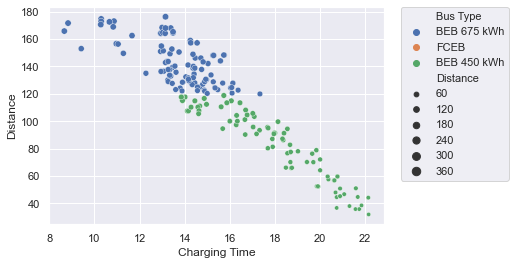

In [69]:
sns.scatterplot(data=blocks, x='Charging Time', y='Distance', hue='Bus Type', size='Distance')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)